# **Quality Control (QC) and filtering**

---------------------

**Motivation:**

Quality control and filtering are the most important steps of single cell data analysis. Allowing low quality cells into your analysis will compromise/mislead your conclusions by adding meaningless data points to your workflow.
The main sources of low quality cells are
- broken cells for which some of their transcripts get lost
- cells isolated together with too much ambient RNA
- missing cell during isolation (e.g. empty droplet in microfluidic machines)
- multiple cells isolated together (multiplets, usually only two cells - doublets).

Such sources can be identified, for example, through the following quality measures:
- *number of transcripts and number of genes detected per cell*: Droplet-based techniques vary in efficiency in capturing mRNA in each cell. However, a cell that has been correctly isolated will have a relatively high amount of transcripts. Droplets with a low amount of transcripts can be broken cells (containing only a portion of transcripts) or empty droplets (capturing only ambient RNA). Droplets with an unusually high number of transcripts might be multiple cells captured into the same droplet. Usually the number of detected genes grow with the number of transcripts, so we can apply similar arguments as for the number of transcripts.
- *percentage of mitochondrial genes per cell:* Droplets with a high proportion of mitocondrial genes might cells with broken membrane, whose cytoplasmic mRNA has spilled out of the cells, but not the RNA contained into the mitochondria. Thus high percentage of mitochondria indicates possible apoptosis.
- *percentage of ribosomal genes per cell:* High proportions of ribosomal genes in a droplet can be due to the degradation of RNA fragments and increased templating of ribosomal RNA fragments.

To use these quality measures, we will look at their distributions across cells (or genes), and try to identify some thresholds to filter out outlying cells.

---------------------------

**Learning objectives:**

- Understand and discuss QC issues and measures from single cell data
- Explore QC graphs and set filtering tools and thresholds
- Analyze the results of QC filters and evaluate necessity for different filtering 
----------------
**Execution time: 40 minutes**

------------------------------------

## Import the packages and load the data

In [1]:
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

In [2]:
sample_2 = sc.read_h5ad('../../Data/notebooks_data/sample_2.h5ad')

We calculate the percentage of ribosomal protein genes and mitochondrial genes into each cell. We look at genes that contain `RPS` or `RPL` and `MT-` into their ID, and calculate their transcript proportion into each cell. We save the result as an observation into `.obs['perc_rp']` and `.obs['perc_mito']`

In [13]:
import re
RP = [ re.match("^RP[SL]",i)!=None for i in sample_2.var_names]
perc_rp = np.sum( sample_2[:,RP].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_rp'] = perc_rp.copy()

In [15]:
MT = ['MT' in i for i in sample_2.var_names]
perc_mito = np.sum( sample_2[:,MT].X, 1 ) / np.sum( sample_2.X, 1 )
sample_2.obs['perc_mito'] = perc_mito.copy()

## Visualize quality measure distributions

We can have a look at quality measures combined together

**Transcripts and Genes distribution:** Here we simply look at the distribution of transcripts per cell and detected genes per cell. Note how the distribution is bimodal. This usually denotes a cluster of low-quality cells and viable cells. Sometimes filtering out the data points on the left-most modes of those graphs removes a lot of cells from a dataset, but this is quite a normal thing not to be worried about. The right side of the distributions show a tail with few cells having a lot of transcripts and genes. It is also good to filter out some of those extreme values - for technical reasons, it will also help in having a better normalization of the data later on.

Text(0.5, 1.0, 'Cells Transcripts distribution')

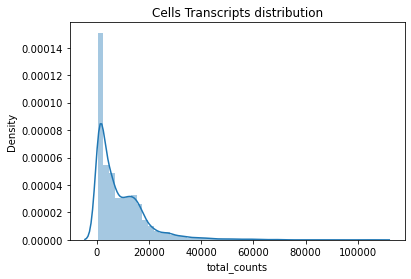

In [5]:
ax = sns.distplot(sample_2.obs['total_counts'], bins=50)
ax.set_title('Cells Transcripts distribution')

Text(0.5, 1.0, 'Distribution of detected genes per cell')

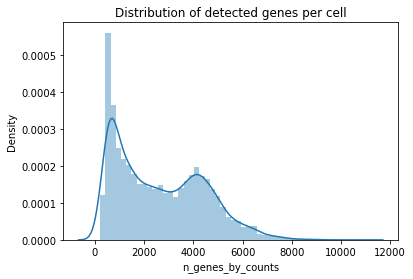

In [6]:
ax = sns.distplot(sample_2.obs['n_genes_by_counts'], bins=50)
ax.set_title('Distribution of detected genes per cell')

**Mitochondrial content**: In this dataset there are few cell with a high percentage of mitochondrial content. Those are precisely 245 if we set 0.1 (that is 10%) as a threshold. A value between 10% and 20% is the usual standard when filtering single cell datasets.

In [19]:
#subsetting to see how many cells have percentage of mitochondrial genes above 10%
sample_2[ sample_2.obs['perc_mito']>0.1, : ].shape

(245, 36601)

Text(0.5, 1.0, 'Distribution of mitochondrial content per cell')

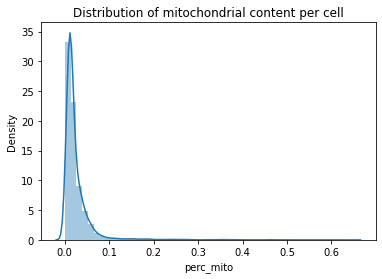

In [18]:
ax = sns.distplot(sample_2.obs['perc_mito'], bins=50)
ax.set_title('Distribution of mitochondrial content per cell')

**Ribosomal content**: The percentage of ribosomal protein genes is higher than the one for mitochondrial genes. Here there is not a typical threshold, since this can change a lot amongst datasets. Here we can choose 25%, corresponding to 225 cells.

Text(0.5, 1.0, 'Distribution of ribosomal content per cell')

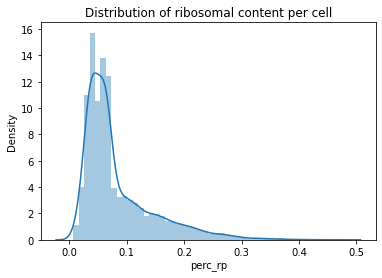

In [28]:
ax = sns.distplot(sample_2.obs['perc_rp'], bins=50)
ax.set_title('Distribution of ribosomal content per cell')

In [29]:
#subsetting to see how many cells have percentage of mitochondrial genes above 10%
sample_2[ sample_2.obs['perc_rp']>0.25, : ].shape

(225, 36601)

**Counts vs Genes:** this is a typical plot, where you look at the total transcripts per cells (x axis) and detected genes per cell (y axis). Usually, those two measures grow together. Points with a lot of transcripts and genes might be multiplets (multiple cells sequenced together as one), while very few transcripts and genes denote the presence of only ambient RNA or very low quality sequencing of a cell. In the two plots below, dots (droplets) are coloured based on the percentage of mitochondrial and ribosomal transcripts. Note how a high proportion of the two measures is often on cells with very low transcripts and genes (bottom left corner of the plots).

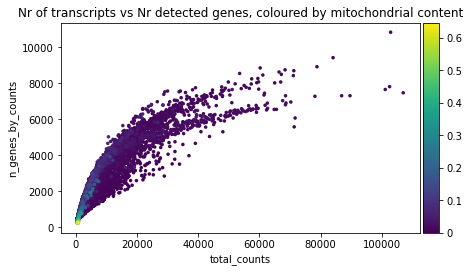

In [17]:
sc.pl.scatter(sample_2, x='total_counts', y='n_genes_by_counts', color='perc_mito', 
              title ='Nr of transcripts vs Nr detected genes, coloured by mitochondrial content',
             size=50)

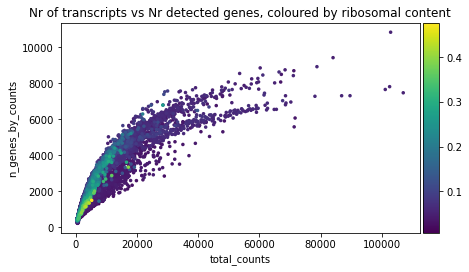

In [27]:
sc.pl.scatter(sample_2, x='total_counts', y='n_genes_by_counts', color='perc_rp', 
              title ='Nr of transcripts vs Nr detected genes, coloured by ribosomal content',
             size=50)

## Choosing thresholds

Let's establish some filtering values by looking at the plots above, and then apply filtering. One way to select thresholds is to look by eye at tails in the distributions plotted above. Other methods plot the PCA projection based on quality measures and remove outliers. However, also with those seemingly more automated techniques, it is always necessary to have a second look at which cells are being filtered. In this case, we simply choose thresholds by looking at the distributions of quality measures.

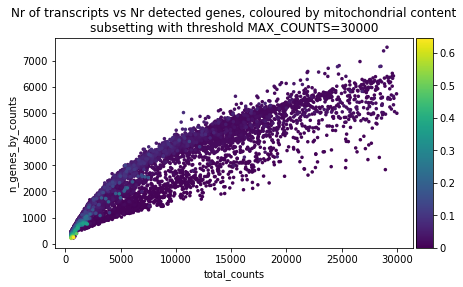

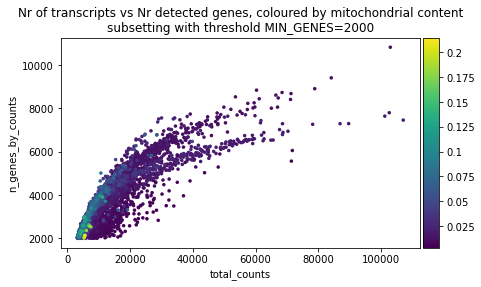

In [30]:
MIN_COUNTS = 5000  #minimum number of transcripts per cell
MAX_COUNTS = 30000 #maximum number of transcripts per cell
MIN_GENES = 2000   #minimum number of genes per cell
MAX_GENES = 6000   #maximum number of genes per cell
MAX_MITO = .1      #mitochondrial percentage threshold)
MAX_RP = .25       #ribosomal percentage threshold)
    
#plot cells filtered by max transcripts
a=sc.pl.scatter(sample_2[ sample_2.obs['total_counts']<MAX_COUNTS ], 
             x='total_counts', y='n_genes_by_counts', color='perc_mito', size=50,
              title =f'Nr of transcripts vs Nr detected genes, coloured by mitochondrial content\nsubsetting with threshold MAX_COUNTS={MAX_COUNTS}')
#plot cells filtered by min genes
b=sc.pl.scatter(sample_2[ sample_2.obs['n_genes_by_counts'] > MIN_GENES ], 
              x='total_counts', y='n_genes_by_counts', color='perc_mito', size=50,
              title =f'Nr of transcripts vs Nr detected genes, coloured by mitochondrial content\nsubsetting with threshold MIN_GENES={MIN_GENES}')
   

 
The following commands filter using the chosen thresholds. Again, **scanpy does not do the ribosomal and mitochondrial QC filterings**, so we do that on our own by subsetting the data. Note for the last two filterings: the parameter `min_cells` remove all those cells showing transcripts for only 10 genes or less - standard values for this parameter are usually between 3 and 10, and do not come from looking at the QC plots.
 Note that this means we will not find clusters of cells containing between 3 and 10 cells.

In [31]:
sc.preprocessing.filter_cells(sample_2, max_counts=MAX_COUNTS)

sc.preprocessing.filter_cells(sample_2, min_counts=MIN_COUNTS)

sc.preprocessing.filter_cells(sample_2, min_genes=MIN_GENES)

sc.preprocessing.filter_cells(sample_2, max_genes=MAX_GENES)

sc.preprocessing.filter_genes(sample_2, min_cells=10)

sample_2 = sample_2[sample_2.obs['perc_mito']<MAX_MITO].copy()

sample_2 = sample_2[sample_2.obs['perc_rp']<MAX_RP].copy()

We have been reducing the data quite a lot from the original >8000 cells. Often, even more aggressive filterings are done. For example, one could have set the minimum number of genes detected to 3000. It would have been anyway in the area between the two modes of the QC plot.

In [32]:
print(f'Cells after filters: {sample_2.shape[0]}, Genes after filters: {sample_2.shape[1]}')

Cells after filters: 3839, Genes after filters: 24343


## Doublet filtering

Another important step consists in filtering out multiplets. Those are in the almost totality of the cases doublets, because triplets and above multiplets are extremely rare. Read [this more technical blog post](https://liorpachter.wordpress.com/2019/02/07/sub-poisson-loading-for-single-cell-rna-seq/) for more explanations about this.

The external tool `scrublet` simulates doublets by putting together the transcripts of random pairs of cells from the dataset. Then it assigns a score to each cell in the data, based on the similarity with the simulated doublets. 

![](https://ars.els-cdn.com/content/image/1-s2.0-S2405471218304745-fx1.jpg)

*Figure: the `scrublet` working principle, from (Wolock et al, 2019)*

An `expected_doublet_rate` of 0.06 (6%) is quite a typical value for single cell data, but if you have a better estimate from laboratory work, microscope imaging or a specific protocol/sequencing machine, you can also tweak the value. 
`random_state` is a number choosing how the simulations are done. Using a specific random state means that you will always simulate the same doublets whenever you run this code. This allows you to reproduce exactly the same results every time and is a great habit to have for reproducibility in your own research.

In [12]:
 sc.external.pp.scrublet(sample_2, 
                        expected_doublet_rate=0.06,
                        random_state=12345)

Automatically set threshold at doublet score = 0.26
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 61.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 3.9%


It seems that the doublet rate is likely to be lower than 6%, meaning that, in this regard, the data has been produced pretty well. We now plot the doublet scores assigned to each cell by the algorithm. We can see that most cells have a low score (the score is a value between 0 and 1). Datasets with many doublets show a more bimodal distribution (look for example at [this example](https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb) from the `scrublet` tutorial), while here we just have a light tail beyond 0.1. 

<AxesSubplot:xlabel='doublet_score', ylabel='Density'>

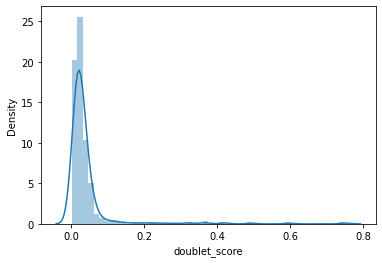

In [13]:
sns.distplot(sample_2.obs['doublet_score'])

We can choose 0.1 as filtering threshold for the few detected doublets or alternatively use the automatic selection of doublets by the algorithm. We will choose the last option and use the automatically chosen doublets.

In [14]:
sample_2 = sample_2[np.invert(sample_2.obs['predicted_doublet'])].copy()

## Evaluation of filtering

A quite basic but easy way to look at the results of our filtering is to normalize and plot the dataset on some projections. Here we use a standard normalization technique that consists of:
- **TPM normalization**: the transcripts of each cell are normalized, so that their total amounts to the same value in each cell. This should make cells more comparable independently of how many transcripts has been retained during cell isolation.
- **Logarithmization**: the logarithm of the normalized transcripts is calculated. This reduce the variability of transcripts values and highlights variations due to biological factors.
- **Standardization**: Each gene is standardized across all cells. This is useful for example  for projecting the data onto a PCA. 

Do not worry about these steps, we will explain them in more detail in the next lessons

In [15]:
# TPM normalization and storage of the matrix
sc.pp.normalize_per_cell(sample_2)
sample_2.layers['umi_tpm'] = sample_2.X.copy()

# Logarithmization and storage
sc.pp.log1p(sample_2)
sample_2.layers['umi_log'] = sample_2.X.copy()

# Select some of the most meaningful genes to calculate the PCA plot later
# This must be done on logarithmized values
sc.pp.highly_variable_genes(sample_2, n_top_genes=15000)

# save the dataset
sample_2.write('../../Data/notebooks_data/sample_2.filt.h5ad')

# standardization and matrix storage
sc.pp.scale(sample_2)
sample_2.layers['umi_gauss'] = sample_2.X.copy()

Now we calculate the PCA projection

In [16]:
sc.preprocessing.pca(sample_2, svd_solver='arpack', random_state=12345)

We can look at the PCA plot and color it by some quality measure and gene expression. We can already see how the PCA has a clear structure with only a few dots sparsed around. It seems the filtering has got a good result.

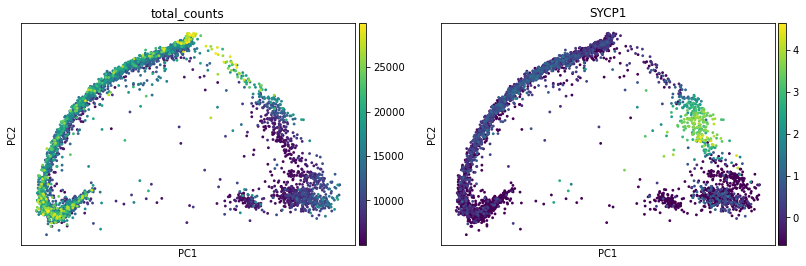

In [17]:
sc.pl.pca(sample_2, color=['total_counts','SYCP1'])

We plot the variance ratio to see how each component of the PCA changes in variability. Small changes in variability denote that the components are mostly modeling noise in the data. We can choose a threshold (for example 15 PCA components) to be used in all algorithms that use PCA to calculate any quantity.

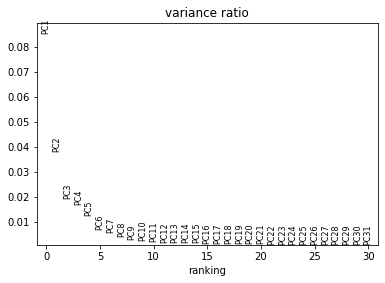

In [18]:
sc.plotting.pca_variance_ratio(sample_2)

We project the data using the UMAP algorithm. This is very good in preserving the structure of a dataset in low dimension, if any is present. We first calculate the neighbors of each cell (that is, its most similar cells), those are then used for the UMAP. The neighbors are calculated using the PCA matrix instead of the full data matrix, so we can choose the number of PCA components to use (parameter `n_pcs`). Many algorithms work on the PCA, so you will see the parameter used again in other places.

In [19]:
sc.pp.neighbors(sample_2, n_pcs=15, random_state=12345)

In [20]:
sc.tools.umap(sample_2, random_state=54321)

The UMAP plot gives a pretty well-structured output for this dataset. We will keep working further with this filtering.

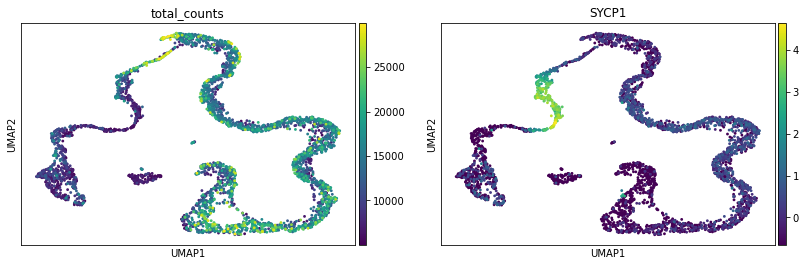

In [21]:
sc.plotting.umap(sample_2, color=['total_counts','SYCP1'])

-------------------------------

## Wrapping up

We have succesfully gone through the filtering of a single cell dataset with good results that can be used further in the data analysis. In the next notebook Normalize and Integrate, we will integrate this dataset (testis cells from a healthy adult man) with the same type of sample from another man. Filtering of the other dataset is in the notebook `Part02_filtering_sample3.ipynb`. **Run the notebook to generate the filtered dataset**. The procedure follows tightly what happens for the dataset we just filtered.

-------------

**Optional:** 

As you could see, this dataset seemed pretty ok to handle. There is another dataset of much lower quality, but will not be integrated in the coming data analysis. Its preprocessing is shown as the submenu `Filtering a low quality sample` in the section `Extra` of the course webpage. In it, we will also show an aggressive filtering workflow using a combination of PCA and automatic outliers detection. Feel free to explore it!